# Tutorial video 4 - PRIMITIVES
[Youtube link](https://www.youtube.com/watch?v=35ykEg3fG4c&t=165s)

Primitive - **smallest** processing instruction for a given **abstraction** level (black-box), no need to worry about implementation.

## Primitives discussed

- Estimator primitive: computes expval of observables with the respective states prepared by q-circuits.

- Sampler primitive (can be used as estimator, but need more postprocessing): returns shot by shot bit strings sampled from the probability distribution of the q-state prepared on the device.

## Circuits to test primitives

Ising model compared with classical.

Based on article [Evidence for the utility of quantum computing before fault tolerance (2023)](https://www.nature.com/articles/s41586-023-06096-3)

Simulating this hamiltonian dynamics:

$H=-\,J\sum _{\langle i,j\rangle }{Z}_{i}{Z}_{j}+h\sum _{i}{X}_{i}$

$e^{-iH_{ZZ}\delta t} = \prod_{\langle i,j \rangle}e^{iJ\delta t Z_i Z_j} = \prod_{\langle i,j \rangle} R_{Z_iZ_j}(-2J\delta t)$

$e^{-iH_{X}\delta t} = \prod_i e^{ih\delta t X_i} = \prod_i R_{X_i}(2h\delta t)$

$i$ - trotter steps IN TOTAL?. $2h\delta t$ - angle.

ZZ on neighbours, X on all qubits





## Transverse field Ising model to demo primitives

Trotter steps fwd in time, then bwd in time. Should be all 0s in the end (but noise)

Map the problem into circuits and operators. (Apply magnetic field after every trotter step)

We could go naively through all pairs i=0,1,2,3... we get a ladder of ZZ gates (more noise). Do compressing. With layers.

In paper - 2d case with 3 layers (RBG). In 1d case: 2 layers:
- EVEN: 01, 23, 45...
- ODD: 12, 34, 56...

In [20]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

# No sqrtY or sqrtYdagger, so let's create using UnitaryGate
SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

########
### U
########
def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, troter_barriers = False, layer_barriers = False): # adding barriers between even odd layers and trotter steps
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if troter_barriers:
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    #
    #   +-------------+
    #  -|             |-     -- S^dagger --------------+----------------------
    #   |  Rzz(-pi/2) |   =                            |
    #  -|             |-     -- S^dagger -- sqrt(Y) -- CX -- sqrt(Y)^dagger --
    #   +-------------+
    #

    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    
    # Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    # Adding Rx gates
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()


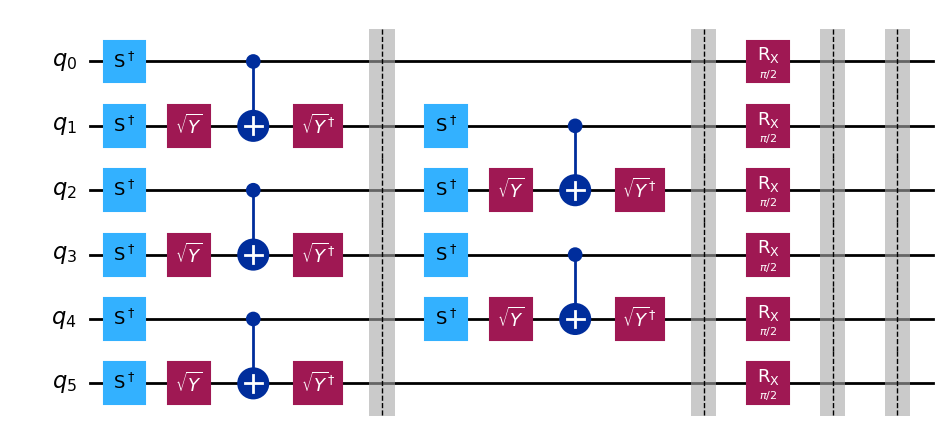

In [21]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, troter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

So looks like now we have a circuit to generate 1 dimensional transverse field trotterized ising model :))

# PT1: SAMPLER

bitstring for fwd and bwd circuit.

First, let's make the MIRRORED (inverse) circuit

In [22]:
########
### U^{-1}
########
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, troter_barriers = False, layer_barriers = False): # adding barriers between even odd layers and trotter steps

    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if troter_barriers:
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # Adding INVERTED Rx gates
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

    # Adding INVERTED Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

    # Adding INVERTED Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()
    





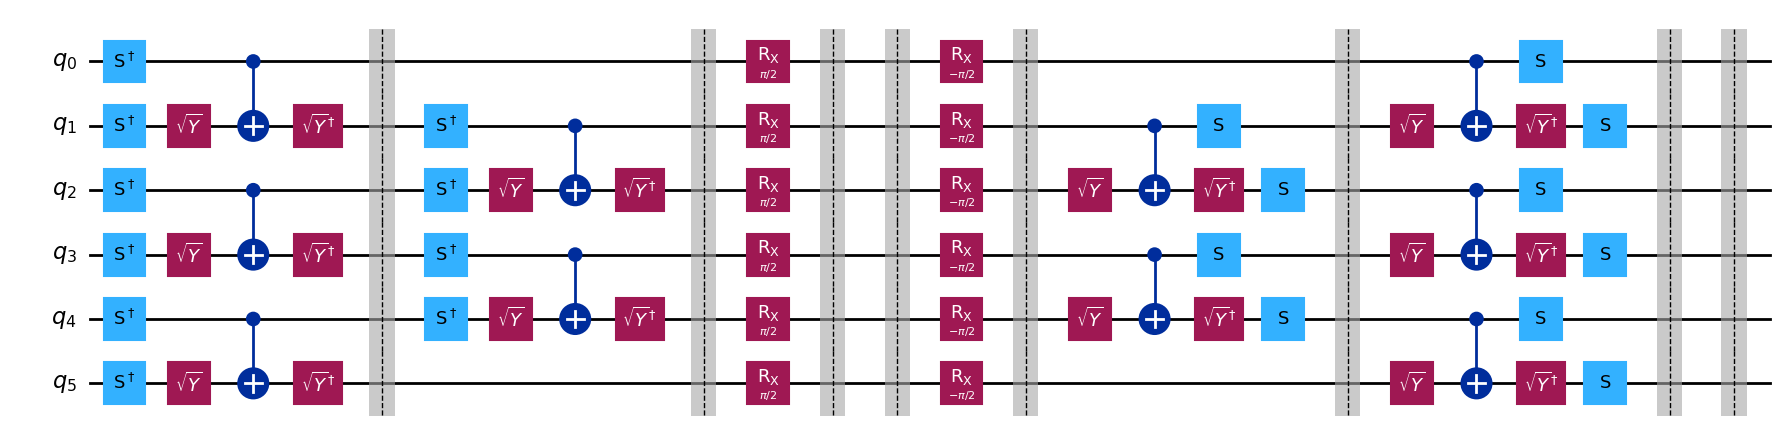

In [23]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, troter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

########
### (all 0s) U * U^{-1} = I (expect all 0s)
########

### RECALL: Qiskit pattern 4 steps
1. Map the problem to circuits and observables
2. Optimize the circuit
3. Execute on hardware
4. Look at the post process results.

# STEP 1: Map the problem to circuits and observables

In [30]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, trotter_step, rx_angle, num_cl_bits=len(measured_qubits), troter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, trotter_step, rx_angle, troter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits)))) # assigning to classical registers 0 and 1
    qc_list.append(qc)

> Note: learn to code any circuit. And learn more about measuring observables/gates.

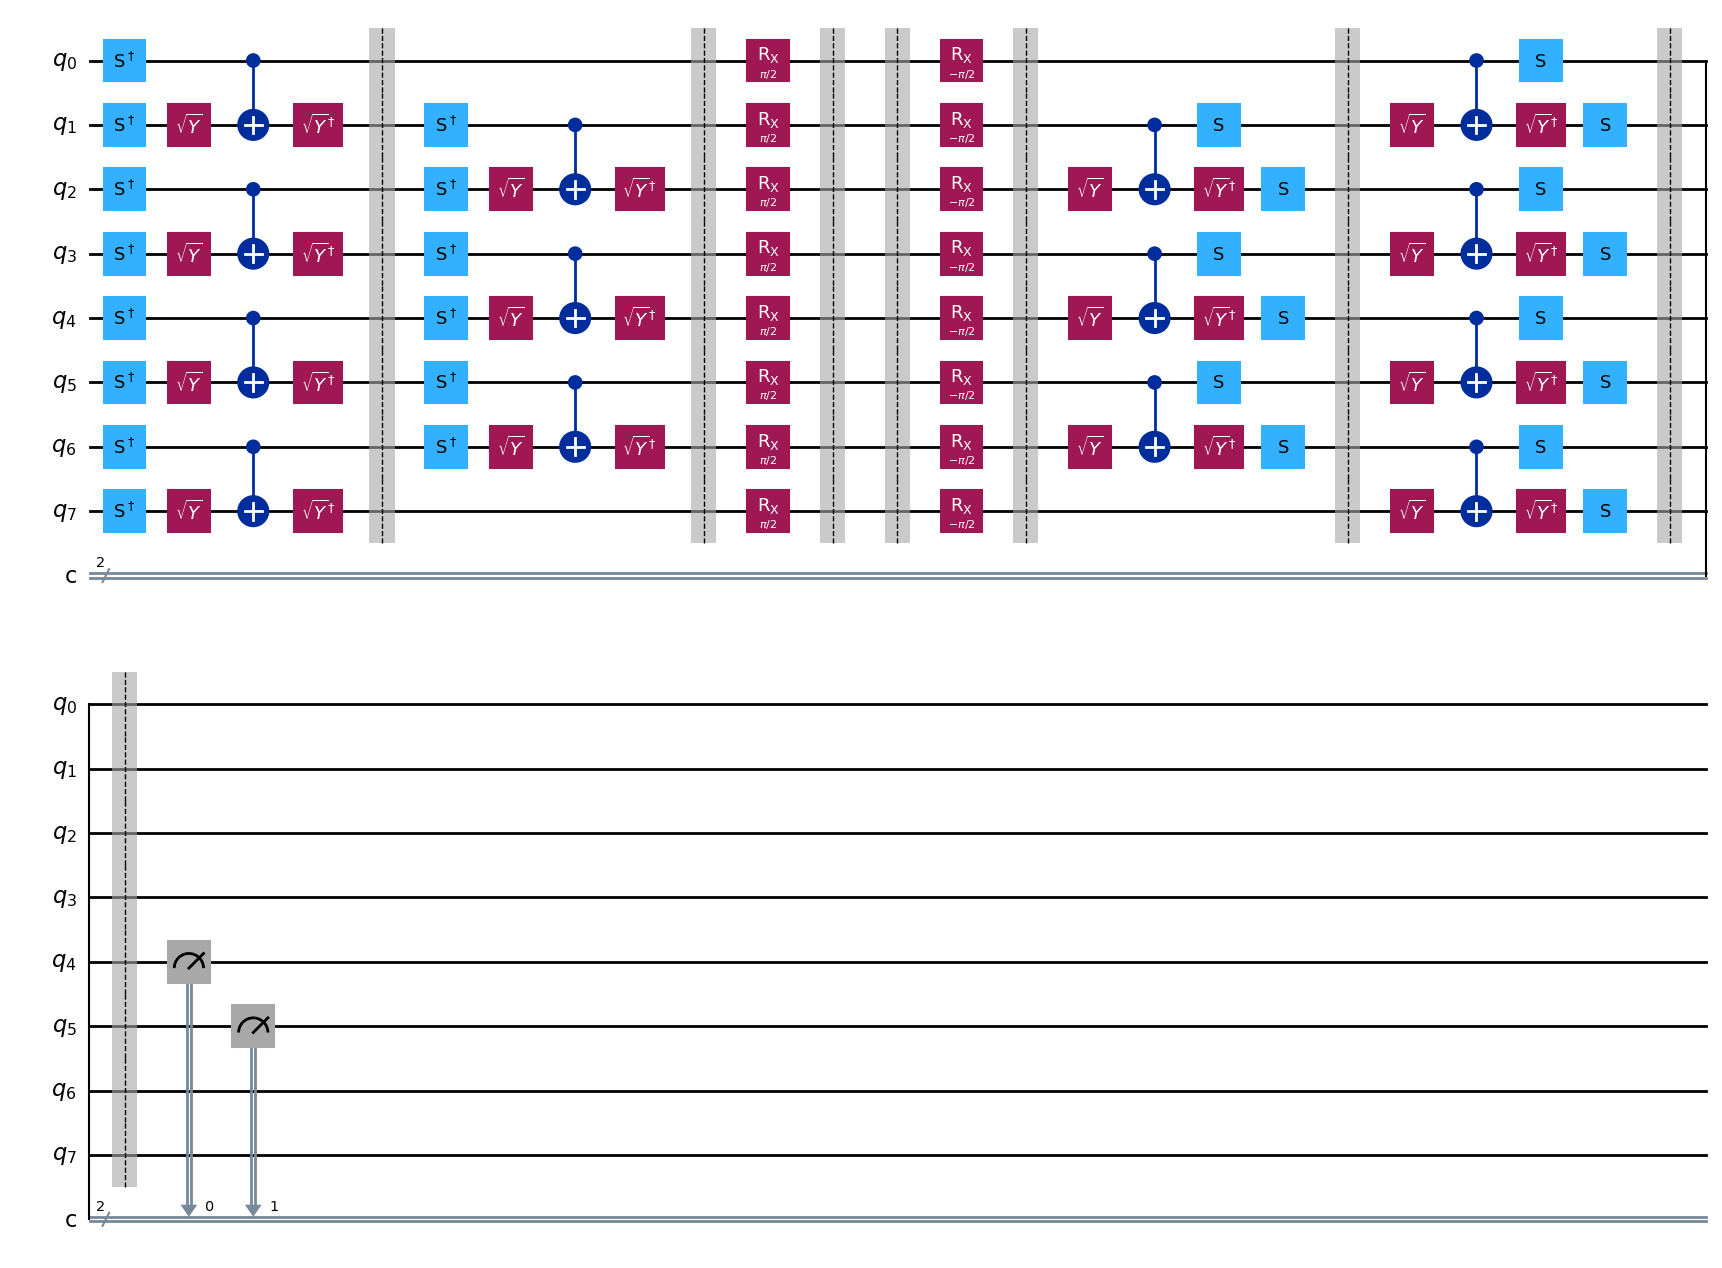

In [27]:
qc_list[1].draw(output='mpl')

# STEP 2: Optimize

In [40]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend1 = service.backend(backend_name)
print("Done getting backend")

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)



Done getting backend


# STEP 3: Execute on hardware

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend1)
sampler.options.dynamical_decoupling.enable = True # since decent amount of idling time???? we need to turn on dynamic decoupling
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(f"Job submitted: {job.job_id()}")

Done running job: cy20faxnrmz000855vg0


> Ask LP for code. To learn from. Cuz now I'm just using qiskit tutorial code for reference (and it's a bit outdated). I need to learn to code from example/mentor.

# STEP 4: Post-processing and plotting

In [44]:
job_id = job.job_id()
job = service.job(job_id)

# Now. Survival probability of all 0 bit string
# sampler makes shots and we count how many of them in the end has all 0s (out of how many shots)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)

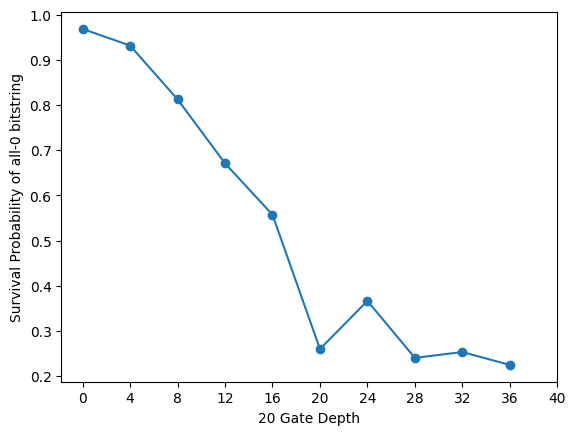

In [49]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, marker='o')
plt.xlabel("20 Gate Depth")
plt.ylabel("Survival Probability of all-0 bitstring")
plt.xticks(np.arange(0, 44, 4))
plt.show()

Wow. Pretty noisy :D

Now let's do similar thing but with the Estimator to get expvals

# PT2: ESTIMATOR

# STEP1: Mapping the problem to circuit and observables

In [50]:
from qiskit.circuit import Parameter
rx_angle = Parameter('rx_angle')
trotter_steps = 2
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle)

# Sweep over rx angle and measure the magnetization. not average, but expval of middle qubit
from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))


# STEP2: Optimize the circuit

In [51]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)

# STEP3: Execute on quantum hardware

In [ ]:
# Define the range of values the parameter can have
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(mode=backend, options=options)

job = estimator.run([(qc_transpiled, observable, rx_angle_list)]) #rx_angle_list - angles that we sweep over in the parameterized rx angle 
print(f"Job submitted: {job.job_id()}")

Done running job: cy215hy6vek0008rbrq0


# STEP4: Post-processing and plotting

(-0.1, 1.1)

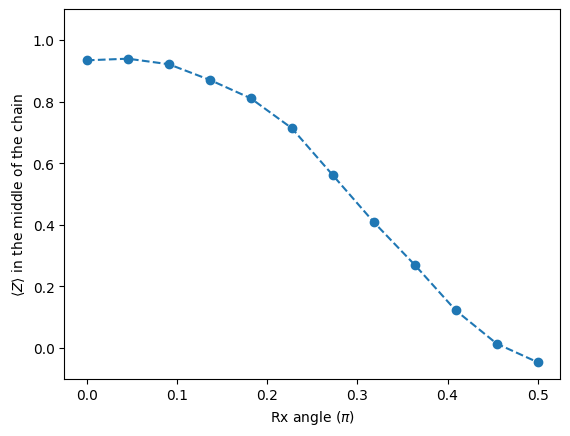

In [55]:
job_id = job.job_id()
job = service.job(job_id)

# getting expvals
exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle$ in the middle of the chain')
plt.ylim(-0.1, 1.1)